DEM CRS   : EPSG:27700
DEM shape : (492, 264)
DEM res   : (2500.0, 2500.0)
Land cells: 36807 / 129888
Lines features (bbox filtered): 14654
Distance (km) land-only stats: min= 0.0 mean= 5.664669990539551 max= 107.5
Suitability land-only stats: min= 0.10000000149011612 mean= 0.6288613080978394 max= 1.0
Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/grid_distance_km.tif
Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/grid_suitability_0_1_piecewise.tif


/var/folders/j3/jt0r4rr56lg340m2qlw6qhnm0000gn/T/ipykernel_86948/952802758.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = plt.cm.get_cmap("viridis").copy()


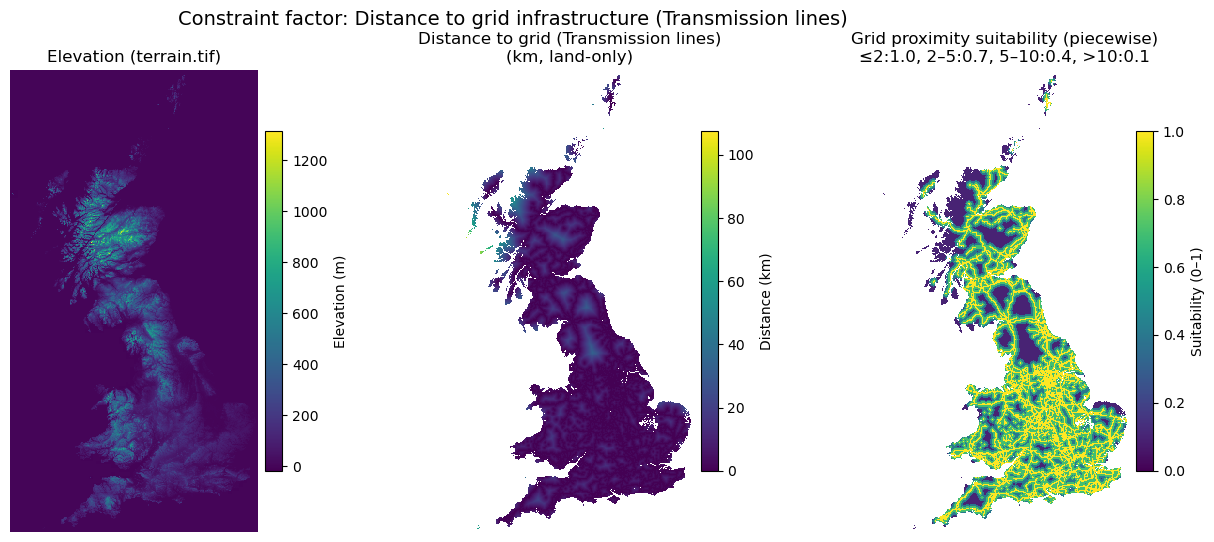

Saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs/grid_triplet_piecewise_landonly.png
All outputs in: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs


In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from shapely.geometry import box


try:
    from scipy.ndimage import distance_transform_edt
except ImportError:
    raise ImportError("缺少 scipy。请安装：conda install scipy  或 pip install scipy")


DATA_DIR = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"
DEM_PATH = os.path.join(DATA_DIR, "terrain.tif")
LINES_PATH = os.path.join(DATA_DIR, "uk_transmission_lines.geojson")

OUT_DIR = os.path.join(DATA_DIR, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)


with rasterio.open(DEM_PATH) as src:
    dem = src.read(1).astype("float32")
    dem_crs = src.crs
    dem_transform = src.transform
    dem_bounds = src.bounds
    dem_shape = dem.shape
    dem_res_x, dem_res_y = src.res  

print("DEM CRS   :", dem_crs)
print("DEM shape :", dem_shape)
print("DEM res   :", (dem_res_x, dem_res_y))


LAND_ELEV_THRESHOLD = 0.0
land_mask = np.isfinite(dem) & (dem > LAND_ELEV_THRESHOLD)

print("Land cells:", int(np.sum(land_mask)), "/", land_mask.size)


dem_bbox = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)
bbox_gdf = gpd.GeoDataFrame(geometry=[dem_bbox], crs=dem_crs)

tmp = gpd.read_file(LINES_PATH, rows=1)
lines_crs = tmp.crs
del tmp

if lines_crs is None:
    raise ValueError("线路 geojson 没有 CRS 信息（crs=None）。请确认数据带坐标系。")

bbox_in_lines = bbox_gdf.to_crs(lines_crs).geometry.iloc[0]
lines = gpd.read_file(LINES_PATH, bbox=bbox_in_lines)

print("Lines features (bbox filtered):", len(lines))

if len(lines) == 0:
    raise ValueError("bbox 过滤后线路数量为 0：可能线路数据范围/坐标系与 DEM 不匹配。")

if lines.crs != dem_crs:
    lines = lines.to_crs(dem_crs)

lines = lines[lines.geometry.notnull()].copy()
lines = lines[~lines.geometry.is_empty].copy()


shapes = ((geom, 1) for geom in lines.geometry)
grid_mask = rasterize(
    shapes=shapes,
    out_shape=dem_shape,
    transform=dem_transform,
    fill=0,
    dtype="uint8",
    all_touched=True  
)

pixel_size = (abs(dem_res_y), abs(dem_res_x))  # (row_spacing, col_spacing)
dist_m = distance_transform_edt(grid_mask == 0, sampling=pixel_size).astype("float32")
dist_km = dist_m / 1000.0


dist_km_land = np.where(land_mask, dist_km, np.nan)

print("Distance (km) land-only stats:",
      "min=", float(np.nanmin(dist_km_land)),
      "mean=", float(np.nanmean(dist_km_land)),
      "max=", float(np.nanmax(dist_km_land)))


#    <=2  -> 1.0
#    2-5  -> 0.7
#    5-10 -> 0.4

suit = np.full(dem_shape, 0.1, dtype="float32")  # 默认 >10 km


# <=2 -> 1.0
# (2,5] -> 0.7
# (5,10] -> 0.4
# >10 -> 0.1
suit[dist_km <= 2.0] = 1.0
suit[(dist_km > 2.0) & (dist_km <= 5.0)] = 0.7
suit[(dist_km > 5.0) & (dist_km <= 10.0)] = 0.4
suit[dist_km > 10.0] = 0.1


suit_land = np.where(land_mask, suit, np.nan)

print("Suitability land-only stats:",
      "min=", float(np.nanmin(suit_land)),
      "mean=", float(np.nanmean(suit_land)),
      "max=", float(np.nanmax(suit_land)))


with rasterio.open(DEM_PATH) as src:
    profile = src.profile.copy()

NODATA_VAL = -9999.0
profile.update(dtype="float32", count=1, nodata=NODATA_VAL, compress="lzw")

out_dist = os.path.join(OUT_DIR, "grid_distance_km.tif")
with rasterio.open(out_dist, "w", **profile) as dst:
    dist_out = np.where(np.isnan(dist_km_land), NODATA_VAL, dist_km_land).astype("float32")
    dst.write(dist_out, 1)

out_suit = os.path.join(OUT_DIR, "grid_suitability_0_1_piecewise.tif")
with rasterio.open(out_suit, "w", **profile) as dst:
    suit_out = np.where(np.isnan(suit_land), NODATA_VAL, suit_land).astype("float32")
    dst.write(suit_out, 1)

print("Saved:", out_dist)
print("Saved:", out_suit)


fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 3, wspace=0.18)

# --- (1) DEM
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(dem, interpolation="nearest")
ax1.set_title("Elevation (terrain.tif)")
ax1.set_axis_off()
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Elevation (m)")

# --- (2) Distance to lines (km)
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(dist_km_land, interpolation="nearest")
ax2.set_title("Distance to grid (Transmission lines)\n(km, land-only)")
ax2.set_axis_off()
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label("Distance (km)")

# --- (3) Piecewise suitability (0-1)
ax3 = fig.add_subplot(gs[0, 2])
cmap3 = plt.cm.get_cmap("viridis").copy()
cmap3.set_bad("white")

im3 = ax3.imshow(suit_land, interpolation="nearest", vmin=0, vmax=1, cmap=cmap3)
ax3.set_title("Grid proximity suitability (piecewise)\n≤2:1.0, 2–5:0.7, 5–10:0.4, >10:0.1")
ax3.set_axis_off()
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)
cbar3.set_label("Suitability (0–1)")

fig.suptitle("Constraint factor: Distance to grid infrastructure (Transmission lines)", fontsize=14)

out_png = os.path.join(OUT_DIR, "grid_triplet_piecewise_landonly.png")
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_png)
print("All outputs in:", OUT_DIR)
